In [1]:
from __future__ import division, print_function

import numpy as np

try:
    from pylab import plt
except ImportError:
    print('Unable to import pylab. R_pca.plot_fit() will not work.')

try:
    # Python 2: 'xrange' is the iterative version
    range = xrange
except NameError:
    # Python 3: 'range' is iterative - no need for 'xrange'
    pass


class R_pca:

    def __init__(self, D, mu=None, lmbda=None):
        self.D = D
        self.S = np.zeros(self.D.shape)
        self.Y = np.zeros(self.D.shape)

        if mu:
            self.mu = mu
        else:
            self.mu = np.prod(self.D.shape) / (4 * np.linalg.norm(self.D, ord=1))

        self.mu_inv = 1 / self.mu

        if lmbda:
            self.lmbda = lmbda
        else:
            self.lmbda = 1 / np.sqrt(np.max(self.D.shape))

    @staticmethod
    def frobenius_norm(M):
        return np.linalg.norm(M, ord='fro')

    @staticmethod
    def shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def svd_threshold(self, M, tau):
        U, S, V = np.linalg.svd(M, full_matrices=False)
        return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

    def fit(self, tol=None, max_iter=1000, iter_print=100):
        iter = 0
        err = np.Inf
        Sk = self.S
        Yk = self.Y
        Lk = np.zeros(self.D.shape)

        if tol:
            _tol = tol
        else:
            _tol = 1E-7 * self.frobenius_norm(self.D)

        #this loop implements the principal component pursuit (PCP) algorithm
        #located in the table on page 29 of https://arxiv.org/pdf/0912.3599.pdf
        while (err > _tol) and iter < max_iter:
            Lk = self.svd_threshold(
                self.D - Sk + self.mu_inv * Yk, self.mu_inv)                            #this line implements step 3
            Sk = self.shrink(
                self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)             #this line implements step 4
            Yk = Yk + self.mu * (self.D - Lk - Sk)                                      #this line implements step 5
            err = self.frobenius_norm(self.D - Lk - Sk)
            iter += 1
            if (iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol:
                print('iteration: {0}, error: {1}'.format(iter, err))

        self.L = Lk
        self.S = Sk
        return Lk, Sk

    def plot_fit(self, size=None, tol=0.1, axis_on=True):

        n, d = self.D.shape

        if size:
            nrows, ncols = size
        else:
            sq = np.ceil(np.sqrt(n))
            nrows = int(sq)
            ncols = int(sq)

        ymin = np.nanmin(self.D)
        ymax = np.nanmax(self.D)
        print('ymin: {0}, ymax: {1}'.format(ymin, ymax))

        numplots = np.min([n, nrows * ncols])
        plt.figure()

        for n in range(numplots):
            plt.subplot(nrows, ncols, n + 1)
            plt.ylim((ymin - tol, ymax + tol))
            plt.plot(self.L[n, :] + self.S[n, :], 'r')
            plt.plot(self.L[n, :], 'b')
            if not axis_on:
                plt.axis('off')

In [2]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns

# Generate carrot-shaped cluster
np.random.seed(42)
carrot_points = np.random.multivariate_normal([0, 0], [[5, 4.5], [4.5, 5]], size=50)

# Rotate the carrot-shaped cluster 45 degrees
rotation_matrix = np.array([[np.cos(np.pi / 4), -np.sin(np.pi / 4)],
                            [np.sin(np.pi / 4), np.cos(np.pi / 4)]])
rotated_carrot_points = np.dot(carrot_points, rotation_matrix)

# Generate outliers in the lower left corner
outliers = np.random.uniform(low=[-7, -8], high=[-3, -4], size=(5, 2))

# Combine the carrot-shaped cluster and outliers
data = np.vstack((rotated_carrot_points, outliers))
og_data = pd.DataFrame({'X': data[:, 0], 'Y': data[:, 1]})
s_row, s_col = og_data.shape
cols = list(og_data.columns)

# Print the DataFrame
print(og_data)
print(f'\nNo of samples : {s_row}\nNo of features(dimensions) : {s_col}')

# Seaborn visualization
plt.figure(figsize=(8, 8))
plt.grid(True)
sns.scatterplot(x='X', y='Y', data=og_data)
plt.title('Carrot-shaped Dataset Rotated 45 Degrees with Outliers in Lower Left Corner')
plt.show()


OSError: /kaggle/input/iot-sensordata/Xdados.txt not found.

## Robust-PCA

A Python implementation of R-PCA using principle component pursuit by alternating directions. The theory and implementation of the algorithm is described here: https://arxiv.org/pdf/0912.3599.pdf (doi > 10.1145/1970392.1970395)

iteration: 1, error: 6.206096299799002
iteration: 100, error: 0.07850509174859428
iteration: 200, error: 0.036145296339583306
iteration: 300, error: 0.027113269753689297
iteration: 400, error: 0.023435562505354297
iteration: 500, error: 0.03868268403703118
iteration: 600, error: 0.11866646050200197
iteration: 700, error: 0.041963159671536576
iteration: 800, error: 0.017963861511344766
iteration: 900, error: 0.0007876189905782211
iteration: 1000, error: 0.006351404759455083
iteration: 1100, error: 0.023866945017093744
iteration: 1111, error: 9.674596928889684e-05
ymin: 0.0, ymax: 30.0


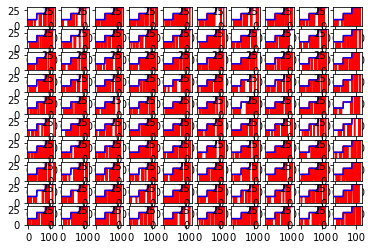

In [3]:
# generate low rank synthetic data
N = 100
num_groups = 3
num_values_per_group = 40
p_missing = 0.2

Ds = []
for k in range(num_groups):
    d = np.ones((N, num_values_per_group)) * (k + 1) * 10
    Ds.append(d)

D = np.hstack(Ds)

# decimate 20% of data 
n1, n2 = D.shape
S = np.random.rand(n1, n2)
D[S < 0.2] = 0



# use R_pca to estimate the degraded data as L + S, where L is low rank, and S is sparse
rpca = R_pca(D)
L, S = rpca.fit(max_iter=10000, iter_print=100)

# visually inspect results (requires matplotlib)
rpca.plot_fit()
plt.show()

RPCA in single time series

In [4]:
names=X.columns[13]
x = X[names]

NameError: name 'X' is not defined

In [5]:
x.shape

NameError: name 'x' is not defined

In [6]:
x.values.reshape(-1,1)

NameError: name 'x' is not defined

In [7]:
x.values.reshape(-1,1).shape

NameError: name 'x' is not defined

In [8]:
# use R_pca to estimate the degraded data as L + S, where L is low rank, and S is sparse
rpca = R_pca(x.values.reshape(-1,1))
L, S= rpca.fit(max_iter=1000, iter_print=100)


NameError: name 'x' is not defined

In [ ]:
principalDf = pd.DataFrame(data = L, columns = ['rpca'])
sensor = 's14'
df = pd.merge(left=principalDf, right=X[sensor], left_on=principalDf.index, right_on=X[sensor].index)

Anomaly analysis

In [ ]:
def scale(A):
    return (A-np.min(A))/(np.max(A) - np.min(A))

In [ ]:
df['sensor_scores'] = S
df['sensor_escoragem_escalado'] = scale(S)

Plotando as anomalias do sensor 14

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(df['sensor_scores'], bins=100);

Plotando scores normalizados

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(df['sensor_escoragem_escalado'], bins=100);

In [ ]:
q1_pc1, q3_pc1 = df['sensor_scores'].quantile([0.25, 0.75])
iqr_pc1 = q3_pc1 - q1_pc1
# Calculate upper and lower bounds for outlier for pc1
lower_pc1 = q1_pc1 - (1.5*iqr_pc1)
upper_pc1 = q3_pc1 + (1.5*iqr_pc1)
    # Filter out the outliers from the pc1
df['sensor_anomalia'] = ((df['sensor_scores']>upper_pc1) | (df['sensor_scores']<lower_pc1)).astype('int')

Plotando as anomalias do sensor 14

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(15,10))
axes[0].plot(df[sensor], color='blue')
axes[1].plot(np.array(S).ravel(), color='red')

axes[0].set_title('Dados originais', fontsize=20)
axes[1].set_title('Score de Anomalia', fontsize=20)

# axes[0].grid()
# axes[1].grid()
plt.tight_layout()
plt.show()

In [ ]:
# visualization
a = X.loc[df['sensor_anomalia'] == 1] 
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df[sensor], color='blue', label='Normal')
_ = plt.plot(a[sensor], linestyle='none', marker='X', color='red', markersize=12, label='Anomalia')
_ = plt.xlabel('Series')
_ = plt.ylabel('leitura do Sensor')
_ = plt.title('Anomalias do Sensor 1')
_ = plt.legend(loc='best')
plt.show();

## Ocorrências de anomalias no sensor

In [ ]:
N = X.shape[0]
plt.scatter(range(N),df['sensor_escoragem_escalado'][:N].cumsum(),marker='1',label='RPCA ')
plt.xlabel('Dados do sensor')
plt.ylabel('Anomalias encontradas')
plt.legend()
plt.show()

Distribuição dos scores das anomalias do sensor

In [ ]:
#2 -- Distributions of Predicted Probabilities of both classes
labels=['Positivo','negativo']
plt.hist(df[df['sensor_anomalia']==1]['sensor_escoragem_escalado'], density=False, bins=100,
             alpha=.5, color='green',  label=labels[0])
plt.hist(df[df['sensor_anomalia']==0]['sensor_escoragem_escalado'], density=False, bins=100,
             alpha=.5, color='red', label=labels[1])
plt.axvline(.5, color='blue', linestyle='--', label='Fronteira de Decisão')
# plt.xlim([0,1])
plt.title('Distribuição dos Valores', size=13)
plt.xlabel('Valores normalizados', size=13)
plt.ylabel('Amostra (normalizados)', size=13)
plt.legend(loc="upper right")

Temos os scores bem ordenados, consideraremos score por volta de 0.8 como anomalia.